# Semi-parametric model in Pyro


Goal: implement the Branin-Hoo example from https://github.com/VDalibard/BOAT in pyro, with both nonparametric and semi-parametric models. 

Also borrows from the example at https://pyro.ai/examples/bo.html. First step is to implement a "structued" GP.

The Branin-Hoo function:

$f(x) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t)\cos(x_1) + s$

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt

In [2]:
def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

## Plot the test function everywhere (obviously can't do this in real-world setting)

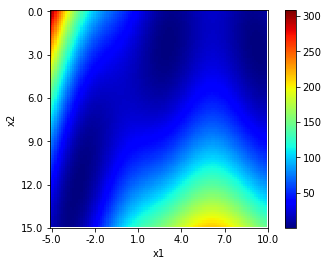

In [3]:
def plot_function(f, n_points=100):
    XX, YY = np.meshgrid(np.linspace(-5, 10, n_points), np.linspace(0, 15, n_points))
    ZZ = f(torch.FloatTensor(np.stack([XX.ravel(), YY.ravel()]).T))
    plt.imshow(ZZ.reshape(n_points, n_points));
    plt.xticks(np.linspace(0, n_points, 6), np.linspace(-5, 10, 6))
    plt.yticks(np.linspace(0, n_points, 6), np.linspace(0, 15, 6))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.set_cmap('jet')
    plt.colorbar()

plt.figure(figsize=(6,4))
plot_function(branin_hoo)

# Before trying Bayesian optimization, let's try different GP models in Pyro.

Would be good to understand how to use the following in Pyro:

1. Standard (nonparametric) GP model, optimizing hyperparameters
2. Standard GP model, but running approximate inference over the hyperparameters (i.e. estimating a posterior distribution)
3. Semi-parametric GP model, following the example BOAT code, running inference over all parameters.

Hopefully we can see how easy it is to fit these models in Pyro, and the differences between the learned models for some fixed set of data.

## Standard GP model, optimizing hyperparameters

Initialize with some random points, then try out a GP.

Use a Matern kernel (an arbitrary choice, at this point) and lognormal priors on all parameters (also an arbitrary choice).

In [4]:
torch.random.manual_seed(666)

N_points = 10
X = torch.rand(N_points, 2)*15 + torch.FloatTensor([-5, 0])
y = branin_hoo(X)

In [5]:
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=2, lengthscale=torch.ones(2)))
gpmodel.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 1.0))
gpmodel.kernel.set_prior("variance", dist.LogNormal(0.0, 1.0))
gpmodel.set_prior("noise", dist.LogNormal(0.0, 1.0))

## This is what the GP looks like before optimizing the parameters

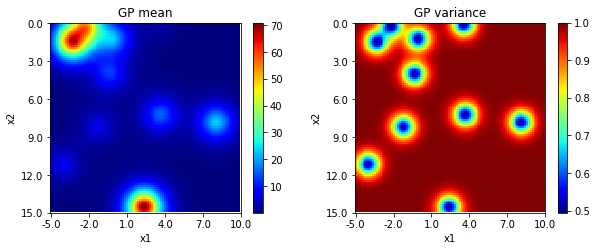

In [6]:
plt.figure(figsize=(10,3.5))
with torch.no_grad():
    plt.subplot(121)
    plt.title("GP mean")
    plot_function(lambda X: gpmodel(X)[0])
    plt.subplot(122)
    plt.title("GP variance")
    plot_function(lambda X: gpmodel(X)[1])

## Now find MAP estimates of the GP parameters

MAP - maximum a posteriori probability  estimate

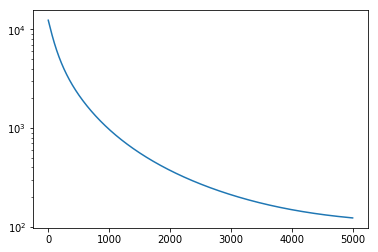

In [7]:
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 5000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpmodel.model, gpmodel.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.semilogy(losses);


In [8]:
print('variance = {}'.format(gpmodel.kernel.variance))
print('lengthscale = {}'.format(gpmodel.kernel.lengthscale.detach().numpy()))
print('noise = {}'.format(gpmodel.noise))

variance = 413.884765625
lengthscale = [2.6005838 3.4767628]
noise = 47.72557830810547


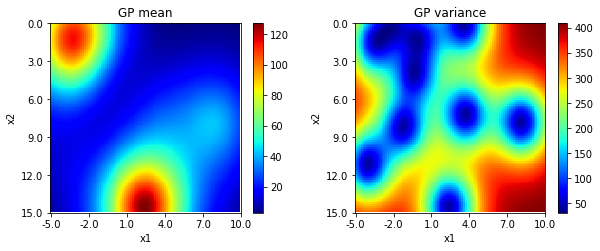

In [9]:
plt.figure(figsize=(10,3.5))
with torch.no_grad():
    plt.subplot(121)
    plt.title("GP mean")
    plot_function(lambda X: gpmodel(X)[0])
    plt.subplot(122)
    plt.title("GP variance")
    plot_function(lambda X: gpmodel(X)[1])

# Standard GP model, doing inference over hyperparameters

This is more along the lines of what is being done in the BOAT baseline nonparametric model. 

Instead of optimizing the GP parameters, we will try to approximate the posteriors of each with a normal distribution.

This is actually very simple to do — we just have to define an `autoguide` for each parameter.

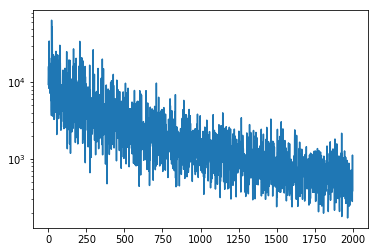

In [10]:
gpmodel_svi = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=2, lengthscale=torch.ones(2)))

# Set priors
gpmodel_svi.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 1.0))
gpmodel_svi.kernel.set_prior("variance", dist.LogNormal(0.0, 1.0))
gpmodel_svi.set_prior("noise", dist.LogNormal(0.0, 1.0))

# Set guides
gpmodel_svi.kernel.autoguide("lengthscale", dist.Normal)
gpmodel_svi.kernel.autoguide("variance", dist.Normal)
gpmodel_svi.autoguide("noise", dist.Normal)

optimizer = torch.optim.Adam(gpmodel_svi.parameters(), lr=0.005)

loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = []

num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpmodel_svi.model, gpmodel_svi.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.semilogy(losses);

### Instead of having specific estimated lengthscales, noises, and variances we now have distributions.

In [11]:
sorted(list(gpmodel_svi.named_buffers()))

[('kernel.lengthscale', tensor([5.2061, 8.3403], grad_fn=<ExpandBackward>)),
 ('kernel.lengthscale_scale',
  tensor([0.3205, 0.4502], grad_fn=<AddBackward0>)),
 ('kernel.variance', tensor(15.9080, grad_fn=<ExpandBackward>)),
 ('kernel.variance_scale', tensor(0.6653, grad_fn=<AddBackward0>)),
 ('noise', tensor(45.9138, grad_fn=<ExpandBackward>)),
 ('noise_scale', tensor(0.6589, grad_fn=<AddBackward0>))]

### There's some amount of variation in the GP mean and variance, then:

(note: the GP means and variances are all independent samples; left and right plots are unrelated)

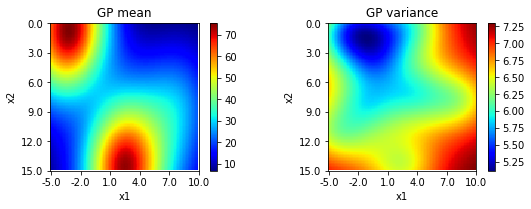

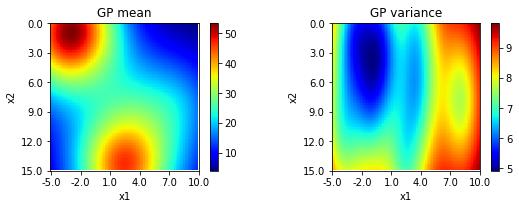

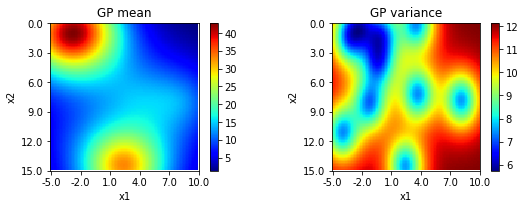

In [12]:
for i in range(3):
    plt.figure(figsize=(8,3))
    with torch.no_grad():
        plt.subplot(121)
        plt.title("GP mean")
        plot_function(lambda X: gpmodel_svi(X)[0])
        plt.subplot(122)
        plt.title("GP variance")
        plot_function(lambda X: gpmodel_svi(X)[1])
        plt.tight_layout();

## Parametric model in pyro

The parametric model used in the BOAT example, with two parameters $\alpha, \beta, \gamma$, is

$g(x; \alpha, \beta, \gamma) = \alpha \cos(x_1) + \beta x_1^4 + x_2^2 + \gamma$

with uniform priors on $\alpha \in [0, 20]$ and $\beta \in [0, 20]$.

The $\gamma$ term isn't actually part of their model, but if I understand the GP code there correctly, they also estimate a mean, and this also has a uniform prior on $[0, 20]$.

First, let's just look at what this parametric model looks like, without fitting it to data at all.


In [13]:
def parametric_fn(X, alpha, beta, gamma):
    x1 = X[...,0]
    x2 = X[...,1]
    return alpha * torch.cos(x1) + beta*torch.pow(x1, 4) + torch.pow(x2, 2) + gamma

def parametric_prior():
    alpha = pyro.sample('alpha', dist.Uniform(0, 20))
    beta = pyro.sample('beta', dist.Uniform(0, 20))
    gamma = pyro.sample('gamma', dist.Uniform(0, 20))
    return alpha, beta, gamma

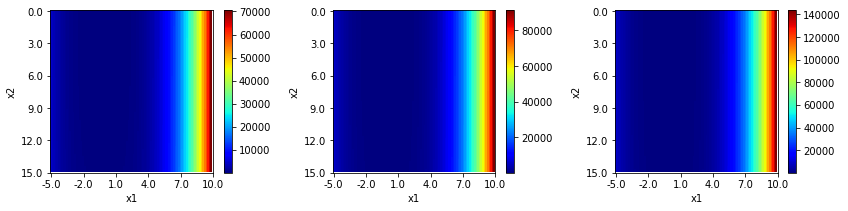

In [19]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plot_function(lambda x: parametric_fn(x, *parametric_prior()))
plt.tight_layout();

Two things of note:

1. This doesn't look like Branin-Hoo at all
2. For the main thing that changes for multiple samples is the overall scale, not the shape

To fit this model to data, we will want to define a `guide` which samples $\alpha, \beta$. This can be as simple as two independent Gaussians (though ideally they would be truncated to $[0, 20]$).

We will also need to define a model class which links the parametric model with the data — in the semi-parametric model, this will be replaced by a GP, but to see what the parametric model would learn by itself we can instead let the errors be small independent Gaussian noise.

In [20]:
def guide(*args):
    mu_a = pyro.param('mu_a', torch.tensor(10.0), constraint=constraints.interval(0, 20))
    mu_b = pyro.param('mu_b', torch.tensor(10.0), constraint=constraints.interval(0, 20))
    mu_c = pyro.param('mu_c', torch.tensor(10.0), constraint=constraints.interval(0, 20))
    sd_a = pyro.param('sd_a', torch.tensor(1.0), constraint=constraints.positive)
    sd_b = pyro.param('sd_b', torch.tensor(1.0), constraint=constraints.positive)
    sd_c = pyro.param('sd_c', torch.tensor(1.0), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(mu_a, sd_a))
    beta = pyro.sample('beta', dist.Normal(mu_b, sd_b))
    gamma = pyro.sample('gamma', dist.Normal(mu_c, sd_c))
    return alpha, beta, gamma

def model_parametric(X, y):
    g = parametric_fn(X, *guide())
    pyro.sample('f', dist.Normal(g, 0.1).independent(1), obs=y)

### The actual inference code is a little bit different here.

We're following the simple example in http://pyro.ai/examples/svi_part_i.html. Main difference is that this uses pyro's optimizers (i.e. `pyro.optim.Adam`), rather than `torch.optim.Adam`; the pyro optimizer does something to automatically extract the relevant parameters, which we explicitly passed to the torch optimizer.

(This setup is simpler, but I can't figure out how to make it work with the GP class…)

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model_parametric, guide, pyro.optim.Adam({'lr': 0.1}), pyro.infer.Trace_ELBO())

In [ ]:
%%time

losses = []

num_steps = 10000
for i in range(num_steps):
    losses.append(svi.step(X, y))
plt.semilogy(losses);

In [ ]:
print("alpha ~ Normal(%0.2f, %0.2f)" % (pyro.param('mu_a'), pyro.param('sd_a')))
print("beta ~ Normal(%0.2f, %0.2f)" %  (pyro.param('mu_b'), pyro.param('sd_b')))
print("gamma ~ Normal(%0.2f, %0.2f)" %  (pyro.param('mu_c'), pyro.param('sd_c')))

### Samples from the parametric model

In [ ]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    with torch.no_grad():
        plot_function(lambda x: parametric_fn(x, *guide()))
plt.tight_layout();

## Semi-parametric model

The semi-parametric model is going to be very close to the parametric model, but will replace the independent normal distribution on the errors with a GP.

We'll do this a little bit differently this time; there are enough parameters that they will be slightly annoying to keep track of, and we'll place everything into a single class that extends torch's `nn.Module`.

This will duplicate some of the code above, with the advantage of being fully self-contained.

In [ ]:
pyro.clear_param_store()

class SemiParametricModel(nn.Module):

    def __init__(self, X, y):
        super().__init__()
        
        # Store data
        D = X.shape[-1]
        self.X = X
        self.y = y
        
        # Define parameters for parametric model
        # TODO: I couldn't figure out how to do this using `pyro.param`, so instead
        #       I am using `nn.Parameter`. This is annoying, because now constraints
        #       need to be handled manually, using the properties below
        self._mu_a = nn.Parameter(torch.zeros(1))
        self._mu_b = nn.Parameter(torch.zeros(1))
        self._mu_c = nn.Parameter(torch.zeros(1))
        self._sd_a = nn.Parameter(torch.zeros(1))
        self._sd_b = nn.Parameter(torch.zeros(1))
        self._sd_c = nn.Parameter(torch.zeros(1))
        
        self._mu_transform = transform_to(constraints.interval(0, 20))
        self._sd_transform = transform_to(constraints.positive)

        # Define GP regressor (leave the data arguments empty for now)
        self.gp = gp.models.GPRegression(torch.empty((0, D)), torch.empty((0,)),
                                         kernel=gp.kernels.Matern52(input_dim=D, lengthscale=torch.ones(D)))

        # Set priors for GP (these are the values used in the semiparametric BOAT model, which assumes noiseless GP)
        self.gp.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 15.0))
        self.gp.kernel.set_prior("variance", dist.Uniform(0.0, 20.0))
        self.gp.set_prior("noise", dist.Uniform(0.0, 1.0))

        # Set guides for GP
        self.gp.kernel.autoguide("lengthscale", dist.Normal)
        self.gp.kernel.autoguide("variance", dist.Normal)
        self.gp.autoguide("noise", dist.Normal)
    
    @property
    def mu_a(self): return self._mu_transform(self._mu_a)

    @property
    def mu_b(self): return self._mu_transform(self._mu_b)

    @property
    def mu_c(self): return self._mu_transform(self._mu_c)

    @property
    def sd_a(self): return self._sd_transform(self._sd_a)

    @property
    def sd_b(self): return self._sd_transform(self._sd_b)
    
    @property
    def sd_c(self): return self._sd_transform(self._sd_c)
    
    def guide(self):
        self.gp.guide()
        alpha = pyro.sample('alpha', dist.Normal(self.mu_a, self.sd_a))
        beta = pyro.sample('beta', dist.Normal(self.mu_b, self.sd_b))
        gamma = pyro.sample('gamma', dist.Normal(self.mu_c, self.sd_c))
        return alpha, beta, gamma

    def model(self):
        alpha = pyro.sample('alpha', dist.Uniform(0, 20))
        beta = pyro.sample('beta', dist.Uniform(0, 20))
        gamma = pyro.sample('gamma', dist.Uniform(0, 20))
        g = parametric_fn(self.X, alpha, beta, gamma)
        residual = self.y - g
        # update the GP to now model the residual from the parametric model
        self.gp.set_data(self.X, residual)
        # call GP model function to actually make the observation
        self.gp.model()
        
    def forward(self, X):
        g = parametric_fn(X, *self.guide())
        mu, sigma = self.gp(X)
        return g + mu, sigma

semi_parametric = SemiParametricModel(X, y)


### It might be helpful to use different learning rates for the different sets of parameters...

When I tried earlier without this, results looked strange.

In [ ]:
param_opt = torch.optim.Adam(semi_parametric.parameters(recurse=False), lr=0.1)
gp_opt = torch.optim.Adam(semi_parametric.gp.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

losses = []

num_steps = 20000
for i in range(num_steps):
    gp_opt.zero_grad()
    param_opt.zero_grad()
    loss = loss_fn(semi_parametric.model, semi_parametric.guide)
    loss.backward()
    gp_opt.step()
    param_opt.step()
    losses.append(loss.item())

plt.semilogy(losses);

In [ ]:
print("alpha ~ Normal(%0.2f, %0.2f)" % (semi_parametric.mu_a.item(), semi_parametric.sd_a.item()))
print("beta ~ Normal(%0.2f, %0.2f)" % (semi_parametric.mu_b.item(), semi_parametric.sd_b.item()))
print("gamma ~ Normal(%0.2f, %0.2f)" % (semi_parametric.mu_c.item(), semi_parametric.sd_c.item()))

In [ ]:
sorted(list(semi_parametric.gp.named_buffers()))

### Samples of the mean function from the semi-parametric model

In [ ]:
for i in range(3):
    plt.figure(figsize=(8,3))
    with torch.no_grad():
        plt.subplot(121)
        plt.title("GP mean")
        plot_function(lambda X: semi_parametric(X)[0])
        plt.subplot(122)
        plt.title("GP mean")
        plot_function(lambda X: semi_parametric(X)[0])
        plt.tight_layout();



### As a reminder, here's the real Branin-Hoo function

In [ ]:
plt.figure(figsize=(6,4))
plot_function(branin_hoo)